In [1]:
import os
# 配列をファイルに書き出す
import scipy.misc
# matlab ファイルの読み込みと保存
import scipy.io
import numpy as np
import urllib.request
import tensorflow as tf

In [2]:
sess = tf.Session()

In [3]:
if not os.path.exists('./mat_data'):
    url = 'http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat'
else:
    pass

In [4]:
original_image_file = 'temp/book_cover.jpg'
style_image_file = 'temp/starry_night.jpg'

In [22]:
vgg_path = 'image_net-vgg-verydeep-19.mat'
original_image_weight = 5.0
style_image_weight = 500.0
regularization_weight = 100
learning_rate = 0.001
generations = 1000
output_generations = 200

In [6]:
# scipy.misc.imread()　numpy配列として画像を読み込む
original_image = scipy.misc.imread(original_image_file)
style_image = scipy.misc.imread(style_image_file)

# ターゲットの形状を取得し、スタイルイメージを同じにする
target_shape = original_image.shape
style_image = scipy.misc.imresize(style_image, target_shape[1] / style_image.shape[1])

/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/envs/seq2seq/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/envs/seq2seq/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/envs/seq2seq/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [7]:
# 論文に基づき、層の順番を定義する。
vgg_layers = ['conv1_1', 'relu1_1',
              'conv1_2', 'relu1_2', 'pool1',
              'conv2_1', 'relu2_1',
              'conv2_2', 'relu2_2', 'pool2',
              'conv3_1', 'relu3_1',
              'conv3_2', 'relu3_2',
              'conv3_3', 'relu3_3',
              'conv3_4', 'relu3_4', 'pool3',
              'conv4_1', 'relu4_1',
              'conv4_2', 'relu4_2',
              'conv4_3', 'relu4_3',
              'conv4_4', 'relu4_4', 'pool4',
              'conv5_1', 'relu5_1',
              'conv5_2', 'relu5_2',
              'conv5_3', 'relu5_3',
              'conv5_4', 'relu5_4']

In [8]:
# matファイルからパラメータを抽出する関数を定義する
def extract_net_info(path_to_params):
    vgg_data = scipy.io.loadmat(path_to_params)
    normalization_matrix = vgg_data['normalization'][0][0][0]
    mat_mean = np.mean(normalization_matrix, axis=(0,1))
    network_weights = vgg_data['layers'][0]
    return(mat_mean, network_weights)

In [9]:
# list vgg_layers の 各層に適切な重みとバイアスを対応させてVGG-19　のネットワークを構成する
def vgg_network(network_weights, init_image):
    network = {}
    image = init_image
    
    #  layer の先頭の文字が　'c' を表す場合
    for i, layer in enumerate(vgg_layers):
        if layer[0] == 'c':
            # StyleNet モデルに対応するように reshape
            weights, bias = network_weights[i][0][0][0][0]
            weights = np.transpose(weights, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            # 畳み込み層の構築
            conv_layer = tf.nn.conv2d(image, tf.constant(weights), (1, 1, 1, 1), 'SAME')
            image = tf.nn.bias_add(conv_layer, bias)
        #  layer の先頭の文字が　'r' を表す場合    
        elif layer[0] == 'r':
            image = tf.nn.relu(image)
        else:
            image = tf.nn.max_pool(image, (1, 2, 2, 1), (1, 2, 2, 1), 'SAME')
        network[layer] = image
    return(network)

In [10]:
# ここでは、元のイメージまたはスタイルイメージに適用するレイヤーを定義する　オリジナルイメージとスタイルイメージの特徴量を抽出する中間層の設定
original_layer = 'relu4_2'
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

In [11]:
# extract_net_infoを実行してネットワークパラメータの取得（平均、重み）
normalization_mean, network_weights = extract_net_info(vgg_path)

# 先頭にサイズ１の次元を追加する （tensorflowの画像演算は４つの次元を必要とするため）
shape = (1,) + original_image.shape
style_shape = (1,) + style_image.shape
original_features = {}
style_features = {}

In [12]:
# image プレースホルダーの作成。このプレースホルダーを使ってネットワークを作成する
image = tf.placeholder('float', shape=shape)
vgg_net = vgg_network(network_weights, image)

In [13]:
# オリジナルイメージの行列を正規化する。
# オリジナルイメージの正規化には、 先に読み込んだ画像を正規化するための正規化行列 norm_mean_matrix を使用する。
original_minus_mean = original_image - normalization_mean
original_norm = np.array([original_minus_mean])

# 構築したオリジナルイメージ層のモデルを session.run(...) し、学習済み CNN モデルから画像の内容層の特徴量 original_featuresを抽出する。
original_features[original_layer] = sess.run(vgg_net[original_layer], feed_dict={image: original_norm})

In [14]:
"""
スタイル画像層のモデルを構築する。オリジナルと同様に正規化した後、
上図の VGG-19 モデルの vgg_layers を構成する layer から、
style_layers = { "relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1" } に該当するlayer を取り出し、種類に応じて、モデルを具体的に構築していく。
"""

image = tf.placeholder('float', shape=style_shape)
vgg_net = vgg_network(network_weights, image)
style_minus_mean = style_image - normalization_mean
style_norm = np.array([style_minus_mean])

# 構築した スタイルイメージ層のモデルを session.run(...) し、学習済み CNN　モデルから画像の内容層の特徴量 _style_featuresを抽出する。
for layer in style_layers:
    layer_output = sess.run(vgg_net[layer], feed_dict={image: style_norm})
    layer_output = np.reshape(layer_output, (-1, layer_output.shape[3]))
    style_gram_matrix = np.matmul(layer_output.T, layer_output) / layer_output.size
    style_features[layer] = style_gram_matrix

In [15]:
# 画像の内容層とスタイル層をノイズ付き合成するための変数＆モデルの構築する。
# ここで構築したモデル（Variable） image が StyleNet のトレーニング対象となる。
vgg_net = vgg_network(network_weights, image)
initial = tf.random_normal(shape) * 0.256
image = tf.Variable(initial)
#この Variable _image_var を VGG-19 モデルの入力とし、モデルを構築する。
# この image を VGG-19 モデルの入力とし、モデルを構築する。
vgg_net = vgg_network(network_weights, image)

In [16]:
# 画像のスタイル層の損失関数を設定する。

# オリジナルイメージの損失値
original_loss = original_image_weight * (2 * tf.nn.l2_loss(vgg_net[original_layer] - original_features[original_layer]) /
                original_features[original_layer].size)

# スタイルイメージの損失値
style_loss = 0
style_losses = []
for style_layer in style_layers:
    layer = vgg_net[style_layer]
    feats, height, width, channels = [x.value for x in layer.get_shape()]
    size = height * width * channels
    features = tf.reshape(layer, (-1, channels))
    style_gram_matrix = tf.matmul(tf.transpose(features), features) / size
    style_expected = style_features[style_layer]
    style_losses.append(2 * tf.nn.l2_loss(style_gram_matrix - style_expected) / style_expected.size)
style_loss += style_image_weight * tf.reduce_sum(style_losses)

# 結果を平滑化するために全変動損失値を加算する
total_var_x = sess.run(tf.reduce_prod(image[:,1:,:,:].get_shape()))
total_var_y = sess.run(tf.reduce_prod(image[:,:,1:,:].get_shape()))
first_term = regularization_weight * 2
second_term_numerator = tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:])
second_term = second_term_numerator / total_var_y
third_term = (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) / total_var_x)
total_variation_loss = first_term * (second_term + third_term)

# 　original_loss（オリジナルイメージの損失値） 　style_loss（スタイルイメージの損失値）　total_variation_loss（全変動損失値）　の結合
# 最終的な StyleNet モデルの損失関数がこれら損失関数の和である　loss
loss = original_loss + style_loss + total_variation_loss

In [17]:
# style layer 情報の抽出
style_layer = 'relu2_1'
layer = vgg_net[style_layer]
feats, height, width, channels = [x.value for x in layer.get_shape()]
size = height * width * channels
features = tf.reshape(layer, (-1, channels))
style_gram_matrix = tf.matmul(tf.transpose(features), features) / size
style_expected = style_features[style_layer]
style_losses.append(2 * tf.nn.l2_loss(style_gram_matrix - style_expected) / style_expected.size)

In [20]:
# ノイズ合成加工モデルに対しての、最適化アルゴリズム（Optimizer）を設定する
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

In [25]:
# 変数を初期化してトレーニングを開始する
sess.run(tf.global_variables_initializer())
for i in range(3000):
    
    sess.run(train_step)

    
    if (i+1) % output_generations == 0:
        print('Generation {} out of {}, loss: {}'.format(i + 1, generations,sess.run(loss)))
        image_eval = sess.run(image)
        best_image_add_mean = image_eval.reshape(shape[1:]) + normalization_mean
        output_file = 'temp_output_{}.jpg'.format(i)
        scipy.misc.imsave(output_file, best_image_add_mean)

Generation 200 out of 1000, loss: 106907984.0


/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/envs/seq2seq/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Generation 400 out of 1000, loss: 57483840.0
Generation 600 out of 1000, loss: 41261156.0
Generation 800 out of 1000, loss: 33292356.0
Generation 1000 out of 1000, loss: 28560416.0
Generation 1200 out of 1000, loss: 25387650.0
Generation 1400 out of 1000, loss: 23068012.0
Generation 1600 out of 1000, loss: 21255612.0
Generation 1800 out of 1000, loss: 19782114.0
Generation 2000 out of 1000, loss: 18546548.0
Generation 2200 out of 1000, loss: 17487614.0
Generation 2400 out of 1000, loss: 16565913.0
Generation 2600 out of 1000, loss: 15752745.0
Generation 2800 out of 1000, loss: 15025730.0
Generation 3000 out of 1000, loss: 14372918.0


In [26]:
# 最終的な出力を保存する
image_eval = sess.run(image)
best_image_add_mean = image_eval.reshape(shape[1:]) + normalization_mean
output_file = 'final_output.jpg'
scipy.misc.imsave(output_file, best_image_add_mean)

/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/envs/seq2seq/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


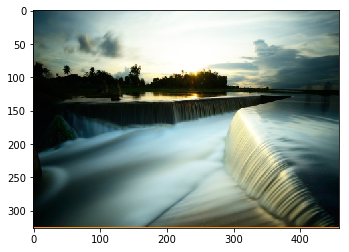

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_img = mpimg.imread(original_image_file)
plt.imshow(original_img)

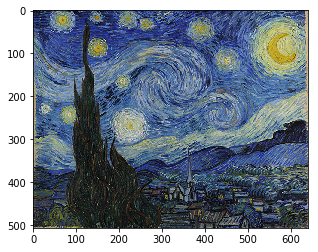

In [36]:
style_img = mpimg.imread(style_image_file)
plt.imshow(style_img)

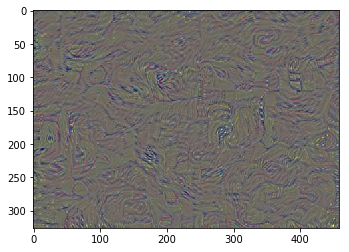

In [38]:
# output_file　の表示
stylenet_img = mpimg.imread('final_output.jpg')
plt.imshow(stylenet_img)